In [ ]:
# !pip install sympy # !pip install pandas>=1.1.4 # !pip install seaborn>=0.11.0 # !pip install opencv-python>=4.6.0 # !pip install pandas>=1.1.4 # !pip install seaborn>=0.11.0 # !pip install filelock # !pip install networkx # !pip install opencv-python>=4.6.0 # !pip install pandas>=1.1.4 # !pip install seaborn>=0.11.0

# **Detección de Armas - Open Data**  

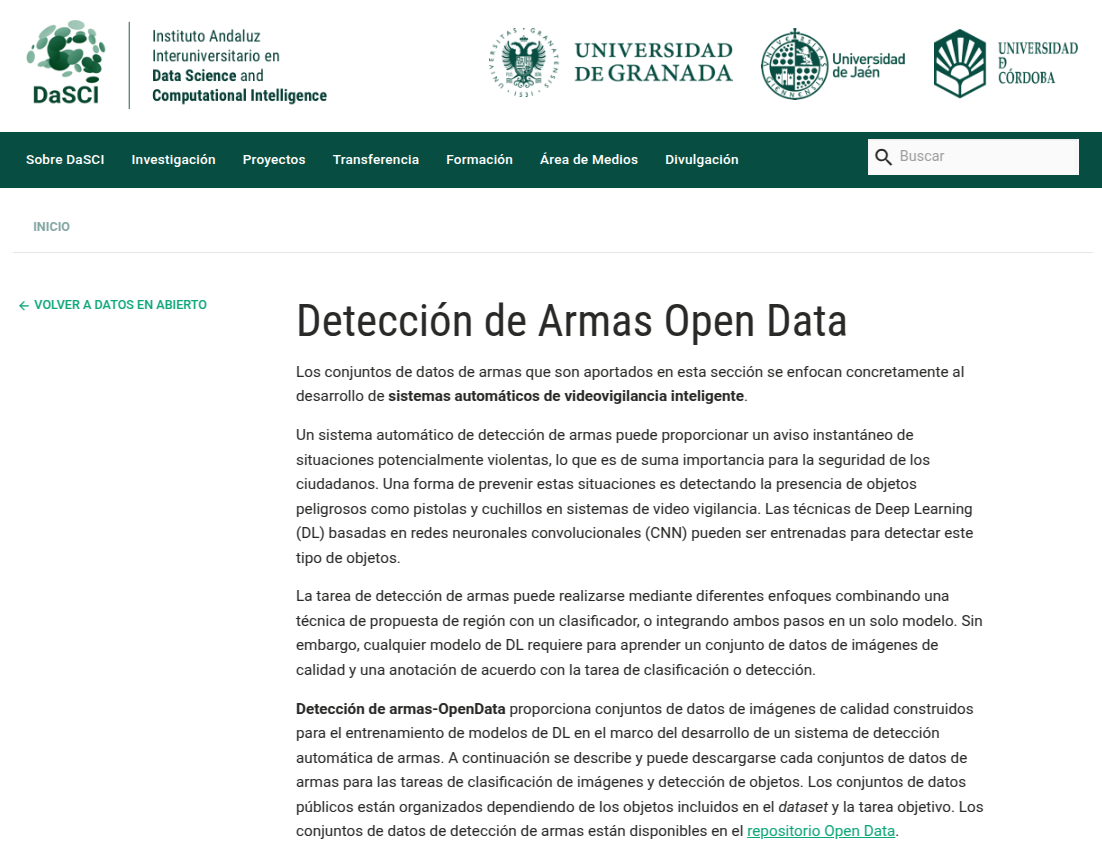

---

## Estudio del dataset

📌 [**Información del Dataset**](https://dasci.es/es/transferencia/open-data/deteccion-de-armas/)  

Este proyecto explora la aplicación de Data Augmentation mediante Diffusion Models sobre un conjunto de datos de detección de armas y otros objetos de naturaleza similar. Por ello este cuenta tanto con pistolas, cuchillos, como una cartera o billetes que los podemos coger "de manera similar" (con la mano). Nuestro objetivo es evaluar si estas técnicas pueden mejorar el rendimiento y la precisión en la tarea de detección de objetos.

Este dataset cuenta con múltiples sub-datasets, donde nos encontramos con la siguiente estructura de directorios:

    Knife_classification  License.md             Pistol_detection  Weapons_and_similar_handled_objects/
    Knife_detection       Pistol_classification  README.md         pictures

Debido a las características del problema en concreto, solo trabajaremos con la parte de Object Detection (OD), es decir, las siguientes clases:

```plaintext
📂 Weapons_and_similar_handled_objects/
 ├── 📂 Sohas_weapon-Detection-YOLOv5/
 │   ├── 📂 obj_train_data/
 │   │   ├── 📂 images/
 │   │   │   ├── train/
 │   │   │   ├── test/
 │   │   ├── 📂 labels/
 │   │   │   ├── train/
 │   │   │   ├── test/
 ├── 📂 Knife_detection/
 ├── 📂 Pistol_detection/
```

Para empezar nos centraremos en:

```plaintext
📂 Weapons_and_similar_handled_objects/
 ├── 📂 Sohas_weapon-Detection-YOLOv5/
 │   ├── 📂 obj_train_data/
```

In [1]:
data_path = "/mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data"
images_path = "/mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/images/train"
labels_path = "/mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/labels/train"

El dataset con el que estamos trabajando cuenta con:

| Tipo   | Conjunto | Cantidad de Imágenes |
|--------|---------|-----------------|
| Images | Test    | 857             |
| Images | Train   | 5002            |
| Labels | Test    | 857             |
| Labels | Train   | 5002            |

---
## **Pipeline de Entrenamiento**

El proceso seguido en este proyecto incluye los siguientes pasos:

1. **Carga del dataset:** Se procesan las imágenes y etiquetas en formato YOLO. (Venían los archivos ya en formato YOLO, por lo que es descargarlos y hacer los data.yaml)
2. **Evaluación del modelo preentrenado:** Se usa un modelo YOLO sin ajuste para obtener un punto de referencia inicial.
3. **Fine-tuning sin Data Augmentation (DA):** Entrenamos el modelo con los datos originales.
4. **Fine-tuning con DA Clásico:** Aplicamos transformaciones como rotaciones y cambios de brillo.
5. **Fine-tuning con Modelos de Difusión:** Generamos imágenes sintéticas para mejorar la variabilidad del dataset.
6. **Fine-tuning con DA Híbrido:** Combinamos ambas técnicas para evaluar su impacto.
7. **Comparación de Resultados:** Se analizan métricas como precisión y recall para cada método.


    ***Nota:** Todos los entrenamientos de modelos se ejecutan en archivos `.py` independientes para optimizar su implementación en servidores, ya que ejecutarlos directamente en un notebook no sería eficiente.* 
---

## **Métricas de Evaluación**

Para evaluar el rendimiento del modelo, se utilizan las siguientes métricas:

- **Precisión (P)**: Proporción de verdaderos positivos sobre todas las predicciones positivas.
- **Recall (R)**: Proporción de verdaderos positivos sobre todas las instancias reales en la clase.
- **mAP@50**: Promedio de precisión cuando IoU (Intersection over Union) es al menos 50%.
- **mAP@50-95**: Promedio de precisión considerando IoU desde 50% hasta 95%.

Estas métricas permiten comparar el impacto de las distintas técnicas de Data Augmentation en la detección de objetos.

---

## 2. **Evaluación del modelo preentrenado**

Vamos a cargar YOLO preentrenado y a evaluar sin finetunning directamente y ver cómo se comporta.

(Como ya habíamos trabajado con YOLO antes y lo teníamos en local, lo cargamos directamente de nuestro dispositivo)

[Para más info](https://docs.ultralytics.com/es)

In [ ]:
# Cargar el modelo entrenado
model = YOLO("yolov8l.pt")  

# Evaluar en el conjunto de validación
metrics = model.val(
    data="/mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/dataset.yaml", 
    split="val",
    device="cuda"
)

# Mostrar métricas clave
print(f"📊 Precisión (mAP@50): {metrics.box.map50:.4f}")
print(f"📊 Precisión (mAP@50-95): {metrics.box.map:.4f}")
print(f"📊 Precisión promedio por clase: {metrics.box.maps}")


Ultralytics 8.3.73 🚀 Python-3.8.20 torch-1.7.1+cu110 CUDA:0 (NVIDIA TITAN Xp, 12196MiB)
YOLOv8l summary (fused): 268 layers, 43,668,288 parameters, 0 gradients, 165.2 GFLOPs


val: Scanning /mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/labels/test.


val: New cache created: /mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/labels/test.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.83it/s]


                   all        857        857   0.000744     0.0109   0.000387   0.000119
                person         85         85    0.00161     0.0588   0.000881   0.000378
               bicycle        140        140          0          0          0          0
                   car        452        452    0.00285    0.00664    0.00144   0.000336
            motorcycle         71         71          0          0          0          0
              airplane         52         52          0          0          0          0
                   bus         57         57          0          0          0          0
Speed: 0.7ms preprocess, 11.6ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /mnt/homeGPU/azapata/runs/detect/val10
📊 Precisión (mAP@50): 0.0004
📊 Precisión (mAP@50-95): 0.0001
📊 Precisión promedio por clase: [ 0.00037761           0   0.0003357           0           0           0  0.00011888  0.00011888  0.00011888  0.00011888  0.00011888  0.00011888 

Como era de esperar, al no haber ajuste específico de clases, los resultados fueron deficientes.

---

## 3. **Fine-tuning sin Data Augmentation (DA):**

Para mejorar los resultados, realizamos fine-tuning con el dataset y así establecemos un **punto de partida para el resto de comparaciones con las diferentes técnicas de DA**

Vemos que esté cuda activo para poder ejecutar en GPU de los servidores.

In [2]:
!python -c "import torch; print(torch.cuda.is_available())"

!python -c "import torch; print(torch.cuda.device_count())"
!python -c "import torch; print(torch.cuda.get_device_name(0))"

!nvcc --version

True
1
NVIDIA TITAN Xp
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


Realizamos el **fine-tuning** del modelo sin utilizar ningún tipo de DA.

📂 **Ruta del script:** `/mnt/homeGPU/azapata/TFG/TrainModels/Weapons/fineTunningOG.py`

### **Resultados Fine-Tuning de YOLO con las clases del dataset original**

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 
                   all        857        857      0.848      0.789      0.886       0.73
                pistol         85         85       0.91      0.918      0.952      0.783
            smartphone        140        140      0.939      0.663      0.922      0.801
                 knife        452        452       0.97      0.903      0.973      0.676
              monedero         71         71      0.642      0.789      0.762       0.63
               billete         52         52      0.851      0.885      0.926      0.823
               tarjeta         57         57      0.777      0.579      0.782      0.665

- **Tiempo de entrenamiento:** 7 horas y 23 minutos. 

---

## 4. **Fine-tuning con DA Clásico:** 
Ahora realizamos el **fine-tuning** del modelo utilizando técnicas de **Data Augmentation clásico**.  

📂 **Ruta del script:** `/mnt/homeGPU/azapata/TFG/TrainModels/Weapons/fineTunningDAclassic.py`

### Resultado de DA Clásico
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 
                   all        857        857      0.791      0.819       0.89      0.741
                pistol         85         85      0.812      0.917       0.94      0.777
            smartphone        140        140      0.868      0.753      0.924      0.802
                 knife        452        452      0.944      0.954      0.983      0.702
              monedero         71         71      0.623      0.792      0.797      0.688
               billete         52         52      0.735      0.923       0.93      0.827
               tarjeta         57         57      0.766      0.574      0.766      0.653

- **Tiempo de entrenamiento:** 7 horas y 23 minutos.  

A pesar de haber aplicado Data Augmentation clásico, los resultados muestran una ligera disminución en el rendimiento en comparación con el modelo original. Esto sugiere que este enfoque de DA no ha sido efectivo para este dataset en particular, al menos en la forma en que se implementó.

---

## 5. **Fine-tuning con Modelos de Difusión:** 
Ahora realizamos el **fine-tuning** del modelo utilizando técnicas de **Data Augmentation con modelos de difusión**.

Para generar las imagenes utilizamos el siguiente archivo:
📂 **Ruta del script:** `/mnt/homeGPU/azapata/TFG/CreateDatasets/Weapons/CreateDM.py`

### **🔹 ¿Cómo se generan las imágenes?**
1. **Carga del Dataset**  
   - Se define la **ruta de las imágenes y etiquetas** en formato YOLO.  
   - Se crean carpetas de **salida** para almacenar las imágenes aumentadas.  

2. **Carga del Modelo de Difusión (Stable Diffusion)**  
   - Se usa un modelo preentrenado localizado en `"/mnt/homeGPU/azapata/models/Realistic_Vision"`.  
   - Se ejecuta en **GPU (CUDA)** para acelerar la generación.  

3. **Procesamiento de Bounding Boxes**  
   - Se cargan las imágenes y las etiquetas con las **coordenadas de los objetos**.  
   - Se filtran las **cajas delimitadoras no solapadas** para evitar distorsiones.  

4. **Generación de Objetos con Stable Diffusion**  
   - Para cada objeto detectado:
     1. Se **recorta el objeto de la imagen original** y se redimensiona a **512x512 píxeles**.  
     2. Se genera un **prompt automático** basado en la categoría del objeto.  
     3. Se usa **Stable Diffusion Img2Img** para **generar una nueva versión realista** del objeto.  
     4. Se **redimensiona** nuevamente al tamaño original y se **reemplaza en la imagen original**.  

5. **Guardado de Imágenes y Etiquetas**  
   - Se almacenan las nuevas imágenes en la carpeta de salida.  
   - Se copian las etiquetas correspondientes a los objetos generados.  

---

#### **🔹 Beneficios de este enfoque**
✅ **Aumenta la diversidad del dataset** sin necesidad de recolectar nuevas imágenes reales.  
✅ **Mejora la capacidad de generalización** del modelo al exponerlo a diferentes variantes de los mismos objetos.  
✅ **Evita el sobreajuste**, especialmente en datasets pequeños o con poca variabilidad.  
✅ **Se conserva la estructura de etiquetas** para poder reutilizar las imágenes sin modificar el pipeline de entrenamiento.

---

#### **🔹 Ejemplo Visual del Proceso**
1️⃣ **Imagen Original con Bounding Boxes**  
📌 Se detectan objetos como **pistolas, cuchillos o teléfonos** en la imagen.

2️⃣ **Generación de Nuevas Variantes con Difusión**  
📌 Se usa Stable Diffusion para **generar versiones realistas de los objetos detectados**.

3️⃣ **Sustitución de Objetos Generados**  
📌 Se reemplazan en la imagen original y se guarda en el dataset aumentado.

*(Nota: Esta imagen es del dataset VisDrone con el que se experimentó anteriormente)*

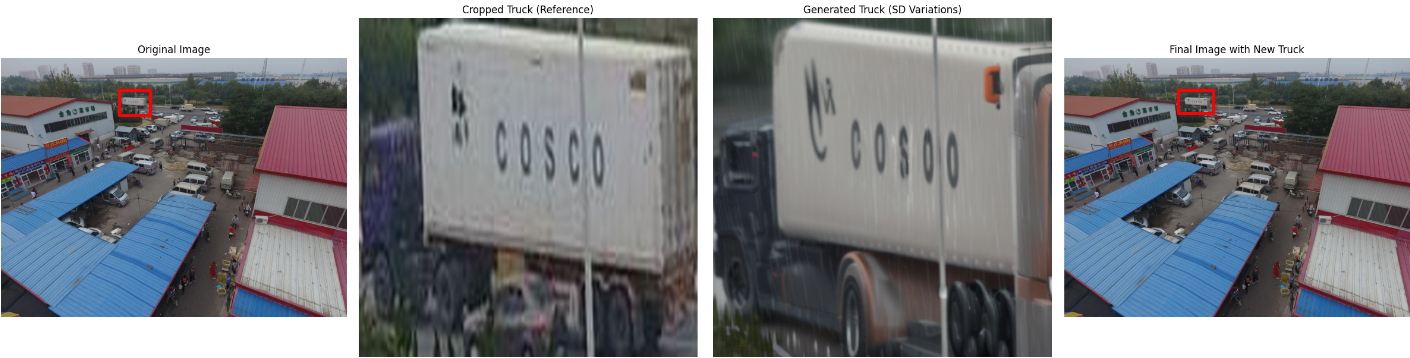
---

📂 **Ruta del script de entrenamiento:** `/mnt/homeGPU/azapata/TFG/TrainModels/Weapons/fineTunningDADM.py`

### Resultado DA con modelos de difusión
               Class     Images  Instances      Box(P          R      mAP50  mAP50-95):
                   all        857        857      0.839      0.839      0.903      0.757
                pistol         85         85      0.871      0.871      0.943      0.789
            smartphone        140        140      0.957      0.804       0.94      0.812
                 knife        452        452      0.965      0.938      0.979      0.705
              monedero         71         71      0.708       0.82      0.812      0.712
               billete         52         52      0.773      0.885      0.935      0.847
               tarjeta         57         57      0.758      0.714      0.811      0.679

- **Tiempo de generación de datos adicionales:** 1 día, 9 horas y 15 minutos.  
- **Tiempo de entrenamiento:** 13 horas y 15 minutos.  
- **Cantidad de imágenes originales:** 89,445.  
- **Tamaño del dataset tras Data Augmentation:** 195,199 imágenes.  
- **Imágenes generadas:** 105754, con una nueva imagen cada 1,13 segundos.  

Si bien los resultados muestran una mejora con respecto al fine-tuning utilizando **DA clásico**, aún no superan el rendimiento del modelo base.

---

## 6. **Fine-tuning con DA Híbrido:**
Ahora realizamos el **fine-tuning** del modelo utilizando técnicas de **Data Augmentation con modelos de difusión y DA clásico sobre este dataset mejorado**.  

📂 **Ruta del script:** `/mnt/homeGPU/azapata/TFG/TrainModels/Weapons/fineTunningHibrid.py`

### Resultado DA hibrido 👑

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 
                   all        857        857      0.868      0.839      0.911      0.769
                pistol         85         85      0.871      0.918      0.942      0.797
            smartphone        140        140      0.982       0.75      0.948      0.819
                 knife        452        452      0.975      0.932      0.984      0.715
              monedero         71         71      0.704      0.817      0.791      0.691
               billete         52         52      0.874      0.904      0.961      0.869
               tarjeta         57         57      0.803      0.716      0.841      0.721

- **Tiempo de entrenamiento:** 14 horas y 7 minutos.  
- **Hay que tener en cuenta que tuvimos que generar los datos para DA DM**
---

## 7. **Comparación de Resultados:** 

Tras realizar el **fine-tuning** del modelo utilizando distintas técnicas de **Data Augmentation**, analizamos y comparamos sus resultados en términos de **precisión (P)**, **recall (R)** y métricas de **mAP (Mean Average Precision)**.  

#### 📊 **Resumen de los Resultados**  

| Técnica de Entrenamiento | mAP@50 | mAP@50-95 | Precisión (P) | Recall (R) | Tiempo de Entrenamiento |
|-------------------------|--------|----------|--------------|----------|------------------|
| **Fine-Tuning sin DA**  | 0.886  | 0.730    | 0.848        | 0.789    | 7h 23m           |
| **DA Clásico**          | 0.890  | 0.741    | 0.791        | 0.819    | 7h 23m           |
| **Modelos de Difusión** | 0.903  | 0.757    | 0.839        | 0.839    | 13h 15m          |
| **DA Híbrido** 👑       | 0.911  | 0.769    | 0.868        | 0.839    | 14h 7m           |

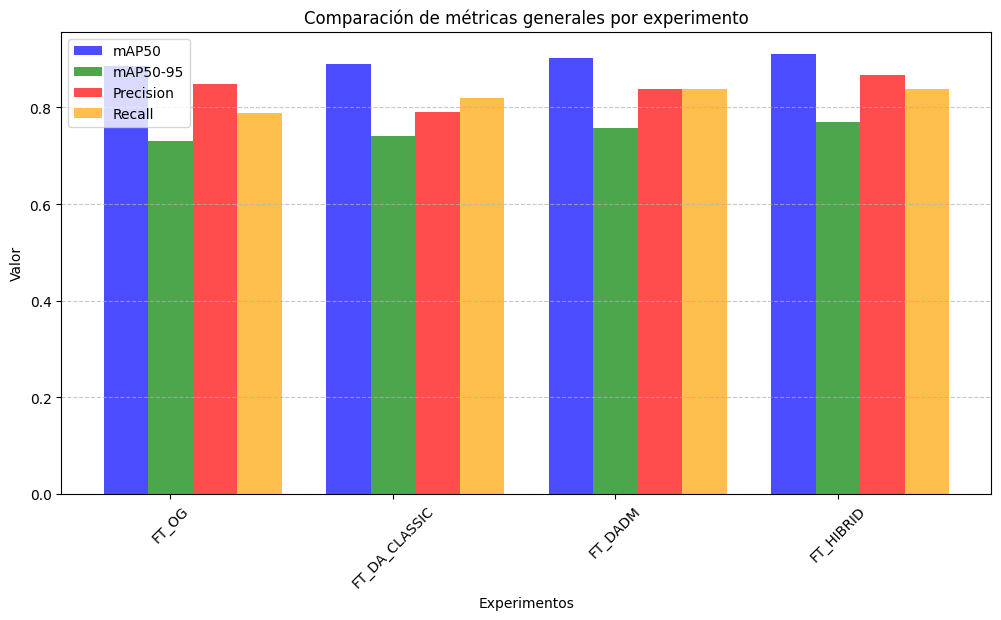

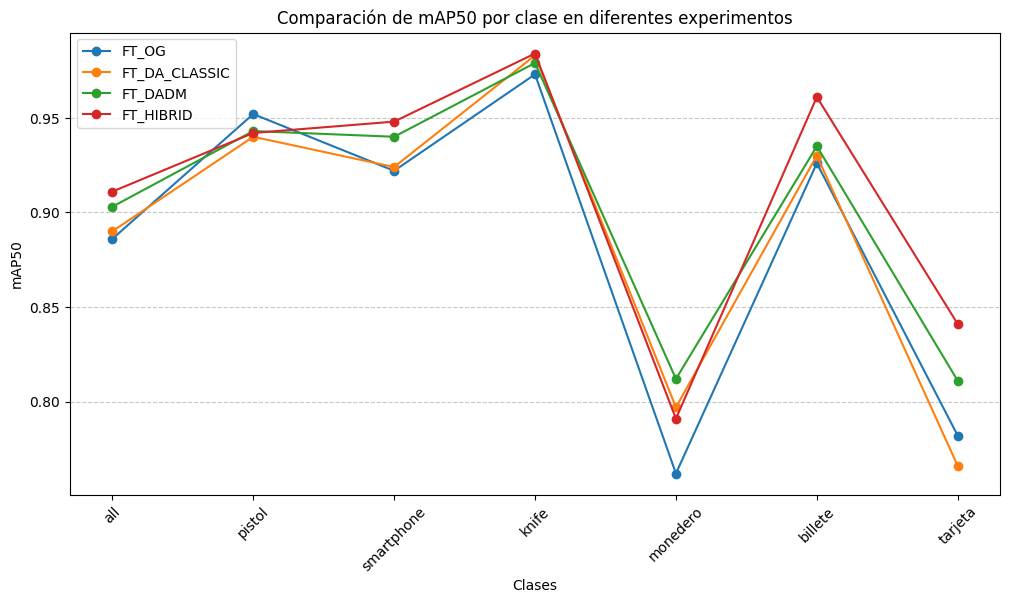

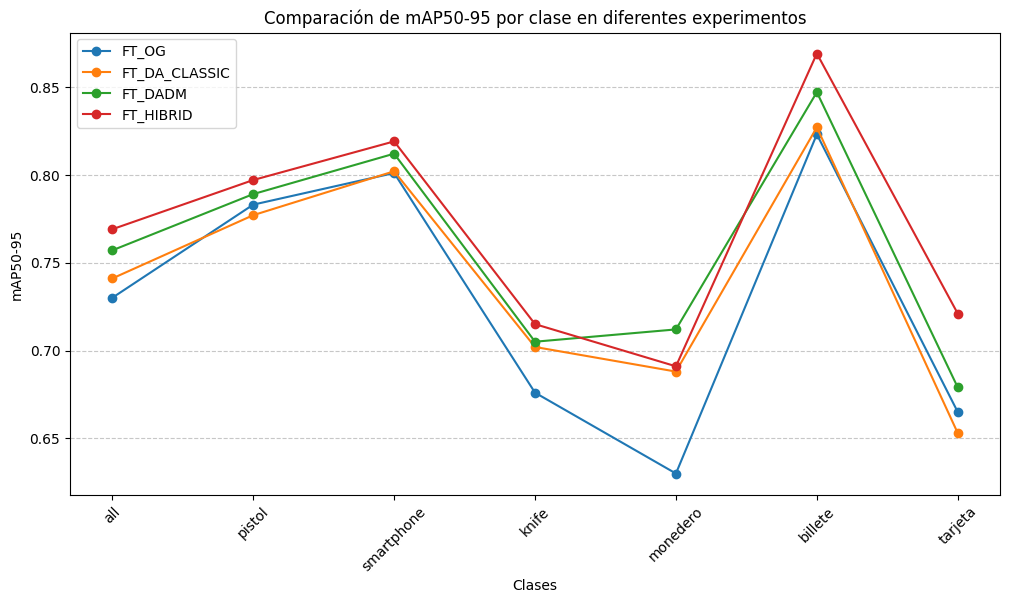

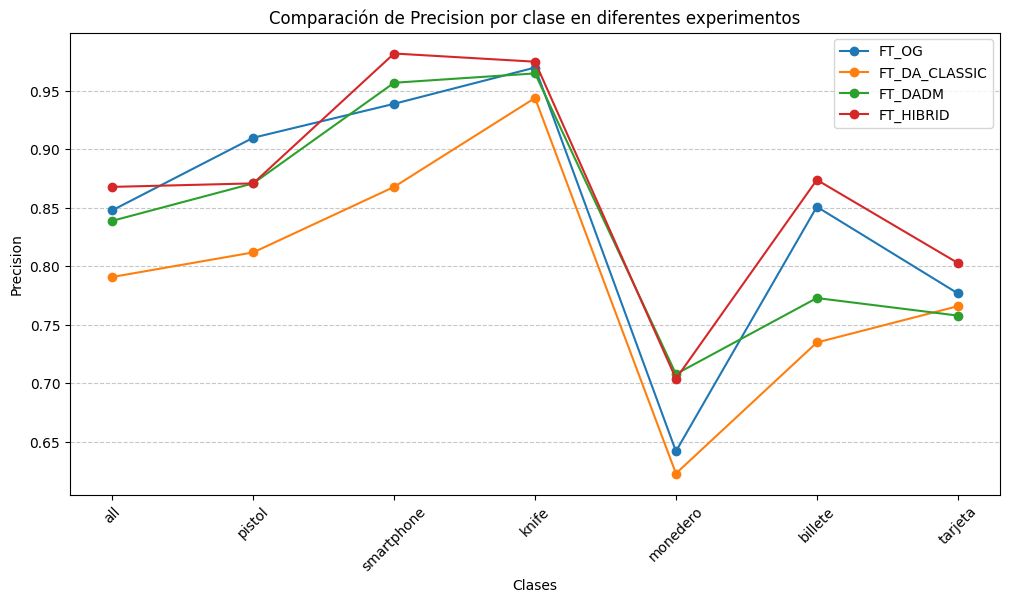

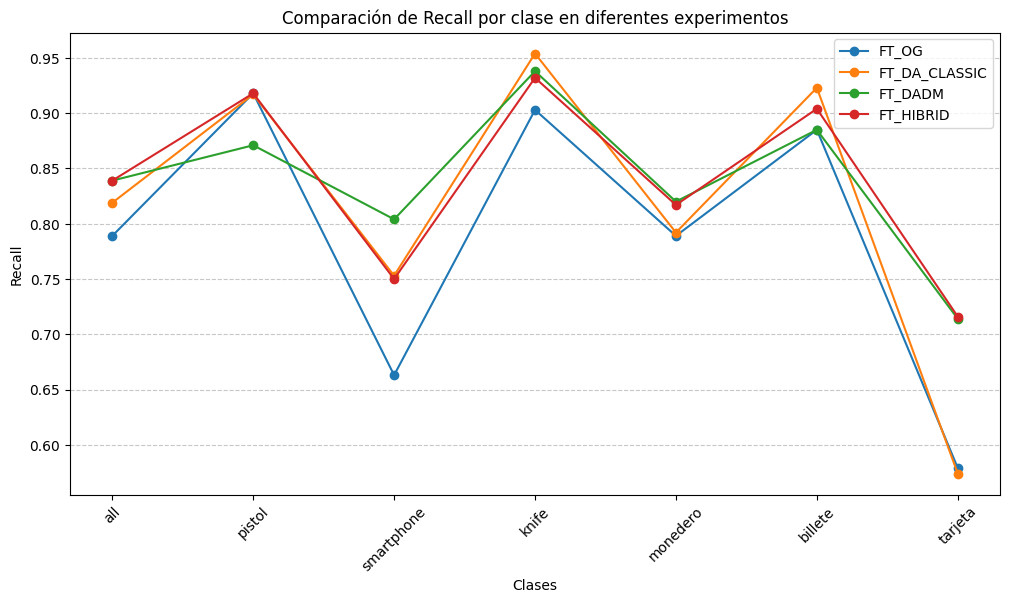

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ruta del archivo CSV
csv_path = "/mnt/homeGPU/azapata/TFG/MetricasDeEntrenamientos/guns/metricas_entrenamientos.csv"

# Cargar el CSV en un DataFrame
df = pd.read_csv(csv_path)

# Filtrar solo la clase 'all' para métricas generales
df_general = df[df["Class"] == "all"]

# Configuración de gráficos
metrics = ["mAP50", "mAP50-95", "Precision", "Recall"]
colors = ["blue", "green", "red", "orange"]

# --- 📊 Gráfico de Barras Agrupadas (Métricas Generales por Experimento) ---
x = np.arange(len(df_general["Experiment"]))  # Posiciones en el eje X
width = 0.2  # Ancho de las barras

plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics):
    plt.bar(x + i * width, df_general[metric], width=width, label=metric, color=colors[i], alpha=0.7)

# Configurar etiquetas y formato
plt.xlabel("Experimentos")
plt.ylabel("Valor")
plt.title("Comparación de métricas generales por experimento")
plt.xticks(x + width, df_general["Experiment"], rotation=45)  # Centrar etiquetas en las barras
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# --- 📈 Gráficos de Líneas (Métricas por Clase en Diferentes Experimentos) ---
for metric in metrics:
    plt.figure(figsize=(12, 6))
    for exp in df["Experiment"].unique():
        df_exp = df[df["Experiment"] == exp]
        plt.plot(df_exp["Class"], df_exp[metric], marker="o", linestyle="-", label=exp)

    plt.xlabel("Clases")
    plt.ylabel(metric)
    plt.title(f"Comparación de {metric} por clase en diferentes experimentos")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()



---
## **🔍 Análisis métrico por técnica**

### **1️⃣ Fine-Tuning sin Data Augmentation (Baseline)**
✅ **mAP@50: 0.886** y **mAP@50-95: 0.730**, lo que indica un buen desempeño en la detección.  
✅ **Precisión (0.848)** y **Recall (0.789)** están equilibrados, lo que significa que el modelo hace buenas predicciones sin generar demasiados falsos positivos.  
✅ **Tiempo de entrenamiento: 7h 23m**, lo que lo hace **eficiente computacionalmente**.  
⚠️ Sin embargo, no explota la generación de datos adicionales para mejorar la generalización.  

### **2️⃣ Data Augmentation Clásico**
✅ **mAP@50 mejora ligeramente (0.890)**, y **mAP@50-95 también sube a 0.741**, lo que sugiere una **ligera mejora en la detección en rangos de IoU más estrictos**.  
⚠️ **La Precisión disminuye de 0.848 a 0.791**, lo que indica **más falsos positivos** (el modelo confunde objetos más a menudo).  
✅ **El Recall aumenta de 0.789 a 0.819**, lo que indica que el modelo detecta **más objetos reales**, pero a costa de aumentar los falsos positivos.  
➡️ **Conclusión:** DA clásico **ayuda a detectar más objetos (mayor recall)**, pero con menor precisión. **No es una mejora clara sobre el baseline.**

### **3️⃣ Modelos de Difusión (DA con imágenes sintéticas)**
✅ **mAP@50 (0.903) y mAP@50-95 (0.757) mejoran notablemente**, lo que sugiere que el modelo **aprende mejor a reconocer armas en diferentes condiciones**.  
✅ **La Precisión (0.839) es más alta que en DA Clásico**, lo que significa que **el modelo comete menos errores de detección**.  
✅ **El Recall (0.839) es mayor que en DA Clásico y Fine-Tuning sin DA**, indicando que el modelo **detecta más objetos sin sacrificar precisión**.  
⚠️ **Tiempo de entrenamiento: 13h 15m**, es decir, **casi el doble que Fine-Tuning sin DA y DA Clásico**.  
➡️ **Conclusión:** **Modelos de Difusión ayudan más que DA Clásico**, permitiendo un balance entre detección y precisión. **Sacrifica velocidad, pero mejora el rendimiento**.  

### **4️⃣ DA Híbrido 👑 (Modelos de Difusión + DA Clásico)**
🏆 **mAP@50 alcanza 0.911 (el más alto)** y **mAP@50-95 sube a 0.769**, lo que demuestra **la mejor capacidad de detección en rangos de IoU exigentes**.  
✅ **Precisión sube a 0.868**, lo que significa que **el modelo es más confiable y comete menos errores de detección**.  
✅ **Recall es de 0.839**, igual que en Modelos de Difusión, lo que indica que sigue detectando un alto número de objetos sin perder precisión.  
⚠️ **Tiempo de entrenamiento: 14h 7m**, el más alto, pero con la mejor mejora en rendimiento.  
➡️ **Conclusión:** **El DA Híbrido logra el mejor equilibrio entre precisión y recall**. Es **el mejor método** para mejorar la detección sin aumentar demasiados falsos positivos.

---

## **📌 Conclusiones Generales**
| 🔍 **Métrica** | 📊 **Mejor técnica** |
|--------------|------------------|
| **Mayor mAP@50** (mejor detección general) | **DA Híbrido (0.911)** |
| **Mayor mAP@50-95** (mejor detección en IoU estrictos) | **DA Híbrido (0.769)** |
| **Mayor Precisión (menos falsos positivos)** | **DA Híbrido (0.868)** |
| **Mayor Recall (más objetos detectados)** | **DA Híbrido y Modelos de Difusión (0.839)** |
| **Menor tiempo de entrenamiento** | **Fine-Tuning sin DA y DA Clásico (7h 23m)** |

✔ **El DA Híbrido es la mejor opción, ya que logra el mejor balance entre precisión y recall, con la mejor capacidad de detección en diferentes niveles de IoU.**  
⚠️ **Si el tiempo de entrenamiento es un problema, el Fine-Tuning sin DA sigue siendo un baseline sólido, aunque con menor rendimiento en detección.**  

🚀 **Conclusión Final:** **Usar Data Augmentation Híbrido es la estrategia óptima** para mejorar el rendimiento del detector de armas sin comprometer precisión.